In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import entr
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import RawBoschCNCDataloader, STFTBoschCNCDataloader, NPYBoschCNCDataLoader, DriftDataLoader, Standardizer

In [3]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )

In [10]:
sudden_config = {
    "base_config": {
        "train_size": 0.3,
        "val_size": 0.2,
        "test_size": 0.5,
        "machines": None,
        "processes": None,
        "periods": None,
    },
    "drift_config": [
        {
            "length": 10000,
            "type": "constant",
            "only_test": False,
            "machines": None,
            "processes": None,
            "periods": ["Feb_2019", "Aug_2019"],
            "transform_fn": None,
        },
        {
            "length": 10000,
            "type": "constant",
            "only_test": False,
            "machines": None,
            "processes": None,
            "periods": None,
            "transform_fn": lambda x: augment_xyz_samples(x, pitch_deg=30),
        },
    ],
}

In [11]:
drift_dataloader = DriftDataLoader(baseloader=base_loader, config=sudden_config)
X_train_raw, y_train = drift_dataloader.access_base_samples_stft(dataset="train")
X_val_raw, y_val = drift_dataloader.access_base_samples_stft(dataset="val")
X_test_raw, y_test = drift_dataloader.access_base_samples_stft(dataset="test")

  0%|          | 0/12530 [00:00<?, ?it/s]

  0%|          | 0/8726 [00:00<?, ?it/s]

  0%|          | 0/21722 [00:00<?, ?it/s]

In [12]:
standardizer = Standardizer()
X_train = standardizer.fit_transform(X_train_raw)
X_val = standardizer.fit_transform(X_val_raw)
X_test = standardizer.transform(X_test_raw)

In [14]:
from torch import tensor
from drift_ml.datasets.bosch_cnc_machining.utils.evaluation import Metrics
from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNEnsembleClassifier

metric_calculator = Metrics()
ensemble = NNEnsembleClassifier(n_ensemble=5)

In [16]:
ensemble.fit(
    fit_args=[
        X_train, 
        y_train[:, np.newaxis], 
        X_val, 
        y_val[:, np.newaxis]
    ],
    fit_kwargs={
        "lrate": 1e-2,
        "epochs": 20
    }
)

/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
DEBUG:root:Final val. performance: AUROC 0.97, AURPC 0.92, F1 0.89
DEBUG:root:Final val. performance: AUROC 0.97, AURPC 0.94, F1 0.93
DEBUG:root:Final val. performance: AUROC 0.99, AURPC 0.94, F1 0.91
DEBUG:root:Final val. performance: AUROC 0.96, AURPC 0.87, F1 0.87


In [71]:
y_base, y_base_scores = ensemble.predict(X_test_base, return_scores=True)

base_entropies = entr(y_base_scores)
metric_calculator.print(y_base_scores, stft_base_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0      0.90538                0.821183       0.842105                0.844149


In [66]:
shift = 40

print(f"Evaluating {shift} degrees pitch shift")
stft_loader = base_loader.get_windowed_samples_as_stft_dataloader(
    transform_fn=lambda x: augment_xyz_samples(x, pitch_deg=shift, yaw_deg=shift)
)
X_test_shift = stft_base_loader.standardize_datasets([stft_loader.X_test])[0]

Evaluating 40 degrees pitch shift


  0%|          | 0/42978 [00:00<?, ?it/s]

In [73]:
y_shift, y_shift_scores = ensemble.predict(X_test_shift, return_scores=True)

shift_entropies = entr(y_shift_scores)
avg_entropy = np.mean(shift_entropies)

metric_calculator.print(y_shift_scores, stft_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0     0.900785                0.705589       0.594093                0.583093


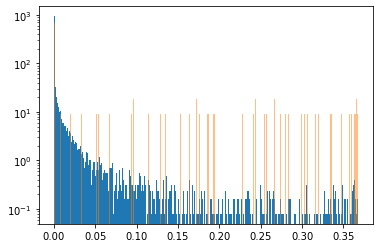

In [77]:
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] == y_base], log=True, density=True, bins=500)
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] != y_base], log=True, density=True, bins=500, alpha=0.5)
plt.show()

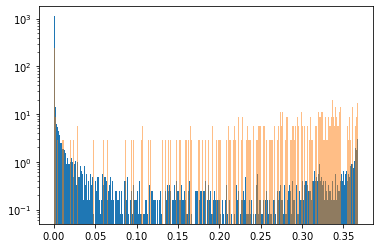

In [78]:
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] == y_shift], log=True, density=True, bins=500)
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] != y_shift], log=True, density=True, bins=500, alpha=0.5)
plt.show()

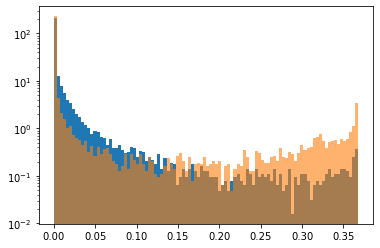

In [98]:
plt.hist(base_entropies, log=True, density=True, bins=100)
plt.hist(shift_entropies, log=True, density=True, bins=100, alpha=0.6)
plt.show()

In [83]:
import seaborn as sns